In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

dataset = pd.read_csv("MH_precrocessed_dataset.csv")
dataset.drop(columns=["Address", "SellerG", "Date", "Propertycount", "Postcode"], inplace=True)

dataset["LogPrice"] = np.log1p(dataset["Price"])
mean_log_price = dataset["LogPrice"].mean()
std_log_price = dataset["LogPrice"].std()

def price_category(price_log):
    if price_log <= (mean_log_price - std_log_price):
        return "Cheap"
    elif (mean_log_price - std_log_price) < price_log <= (mean_log_price + std_log_price):
        return "Affordable"
    else:
        return "Expensive"

dataset["Price_Category"] = dataset["LogPrice"].apply(price_category)

#Downsampling to balance classes
df_cheap = dataset[dataset["Price_Category"] == "Cheap"]
df_affordable = dataset[dataset["Price_Category"] == "Affordable"]
df_expensive = dataset[dataset["Price_Category"] == "Expensive"]

min_size = min(len(df_cheap), len(df_expensive))

df_affordable_downsampled = resample(df_affordable,
                                     replace=False,
               S                      n_samples=min_size,
                                     random_state=42)

df_balanced = pd.concat([df_cheap, df_expensive, df_affordable_downsampled])

print("Class distribution after downsampling:")
print(df_balanced["Price_Category"].value_counts())

# Label encode target
label_encoder = LabelEncoder()
df_balanced["PriceCategoryEncoded"] = label_encoder.fit_transform(df_balanced["Price_Category"])

X = df_balanced.drop(columns=["Price", "LogPrice", "Price_Category", "PriceCategoryEncoded"])
y = df_balanced["PriceCategoryEncoded"]

# identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Create preprocessing pipeline (scaling + encoding)
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

pca_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=5))
])

# PCA transformation
X_pca = pca_pipeline.fit_transform(X)

explained_variance = pca_pipeline.named_steps["pca"].explained_variance_ratio_
print("\nExplained variance ratio of each principal component:")
for i, ratio in enumerate(explained_variance, 1):
    print(f"PC{i}: {ratio:.4f}")
print(f"Total explained variance by first 5 components: {explained_variance.sum():.4f}")

# Training Random Forest with cross-validation
rf = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf, X_pca, y, cv=10)

print("\nRandom Forest 10-fold cross-validation accuracy scores:")
print(scores)
print(f"Average accuracy: {np.mean(scores):.4f}")


Class distribution after downsampling:
Price_Category
Cheap         315
Expensive     295
Affordable    295
Name: count, dtype: int64

Explained variance ratio of each principal component:
PC1: 0.2568
PC2: 0.1177
PC3: 0.0828
PC4: 0.0731
PC5: 0.0634
Total explained variance by first 5 components: 0.5938

Random Forest 10-fold cross-validation accuracy scores:
[0.86813187 0.65934066 0.69230769 0.72527473 0.75824176 0.67777778
 0.72222222 0.75555556 0.71111111 0.66666667]
Average accuracy: 0.7237


In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

# Random Forest model
rf = RandomForestClassifier(random_state=42)

# 10k fold cv
y_pred = cross_val_predict(rf, X_pca, y, cv=10)

print(classification_report(y, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

  Affordable       0.59      0.52      0.55       295
       Cheap       0.79      0.85      0.82       315
   Expensive       0.77      0.79      0.78       295

    accuracy                           0.72       905
   macro avg       0.71      0.72      0.72       905
weighted avg       0.72      0.72      0.72       905



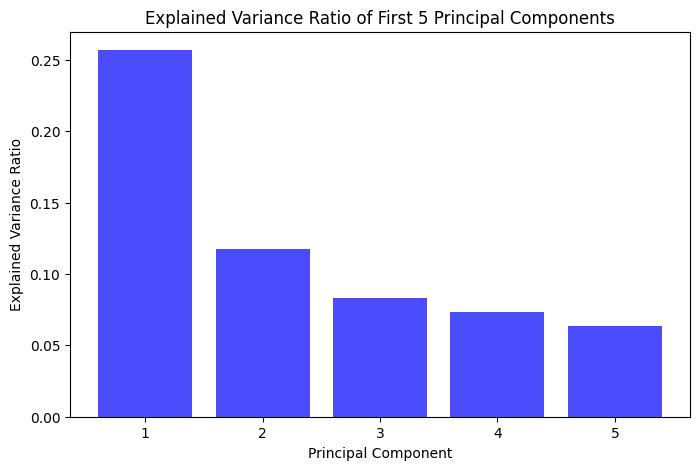

In [8]:
import matplotlib.pyplot as plt

explained_variance = pca_pipeline.named_steps["pca"].explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.bar(range(1, 6), explained_variance, alpha=0.7, color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of First 5 Principal Components')
plt.xticks(range(1, 6))
plt.show()


In [9]:
pca_model = pca_pipeline.named_steps['pca']

loadings = pca_model.components_

feature_names = numeric_features + categorical_features

print("PCA Bileşen Yükleri (Loadings):")
for i, component in enumerate(loadings, 1):
    print(f"\nPC{i}:")
    for feature, coef in zip(feature_names, component):
        print(f"  {feature}: {coef:.4f}")


PCA Bileşen Yükleri (Loadings):

PC1:
  Rooms: 0.4884
  Distance: 0.1293
  Bedroom2: 0.4775
  Bathroom: 0.4207
  Car: 0.2677
  Landsize: 0.0479
  BuildingArea: 0.4389
  YearBuilt: -0.0244
  Lattitude: -0.0649
  Longtitude: 0.1266
  Suburb: -0.0009
  Type: -0.0005
  Method: -0.0007
  CouncilArea: -0.0007
  Regionname: -0.0001

PC2:
  Rooms: 0.0203
  Distance: 0.4127
  Bedroom2: -0.0007
  Bathroom: -0.0460
  Car: 0.1094
  Landsize: 0.1303
  BuildingArea: 0.0929
  YearBuilt: 0.2980
  Lattitude: 0.5655
  Longtitude: -0.5107
  Suburb: -0.0005
  Type: 0.0024
  Method: 0.0012
  CouncilArea: 0.0011
  Regionname: -0.0034

PC3:
  Rooms: -0.1164
  Distance: 0.4730
  Bedroom2: -0.1162
  Bathroom: -0.0068
  Car: 0.1087
  Landsize: -0.0871
  BuildingArea: -0.0257
  YearBuilt: 0.6809
  Lattitude: -0.3400
  Longtitude: 0.3166
  Suburb: -0.0008
  Type: -0.0020
  Method: 0.0009
  CouncilArea: -0.0004
  Regionname: -0.0060

PC4:
  Rooms: -0.0696
  Distance: 0.0595
  Bedroom2: -0.0581
  Bathroom: -0.0482


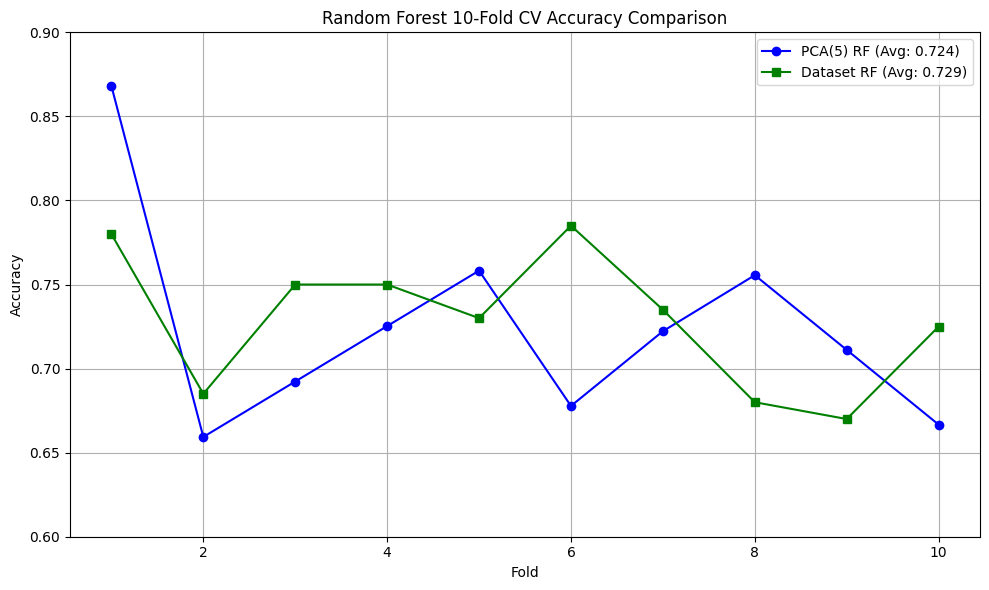

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# PCA(5) ile yapılan Random Forest sonuçları
scores_pca5 = np.array([0.86813187, 0.65934066, 0.69230769, 0.72527473, 0.75824176,
                        0.67777778, 0.72222222, 0.75555556, 0.71111111, 0.66666667])
mean_pca5 = scores_pca5.mean()

# dataset ile yapılan Random Forest sonuçları
scores_dataset = np.array([0.78,  0.685, 0.75,  0.75,  0.73,  0.785, 0.735, 0.68,  0.67,  0.725])
mean_dataset = scores_isi.mean()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), scores_pca5, marker='o', label=f"PCA(5) RF (Avg: {mean_pca5:.3f})", color='blue')
plt.plot(range(1, 11), scores_isi, marker='s', label=f"Dataset RF (Avg: {mean_isi:.3f})", color='green')

plt.title("Random Forest 10-Fold CV Accuracy Comparison")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0.6, 0.9)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
